# London Fire Incidents Dimensionality Reduction

In [1]:
%matplotlib inline 
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

### Downloading and loadng the data

In [2]:
# Loading the data
# import data_download #This module has to be loaded to download the data automatically

data_dir = "LFB-data"

LFB_data = pd.read_excel(os.path.join("LFB-data","lfb-incidents-for-last-3-years.xlsx"))
LFB_data.head()

,IncidentNumber,DateOfCall,CalYear,TimeOfCall,HourOfCall,IncidentGroup,StopCodeDescription,SpecialServiceType,PropertyCategory,PropertyType,...,FirstPumpArriving_AttendanceTime,FirstPumpArriving_DeployedFromStation,SecondPumpArriving_AttendanceTime,SecondPumpArriving_DeployedFromStation,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,PumpHoursRoundUp,Notional Cost (£),NumCalls
0,000006-01012019,01 Jan 2019,2019,00:01:45,0,Special Service,Special Service,Lift Release,Dwelling,Purpose Built Flats/Maisonettes - 4 to 9 storeys,...,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,333.0,2.0
1,000019-01012019,01 Jan 2019,2019,00:04:33,0,Fire,Secondary Fire,NaN,Outdoor,Tree scrub,...,357.0,Edmonton,NaN,NaN,1.0,1.0,1.0,1.0,333.0,1.0
2,000020-01012019,01 Jan 2019,2019,00:04:39,0,False Alarm,False alarm - Good intent,NaN,Outdoor,Domestic garden (vegetation not equipment),...,318.0,Southgate,NaN,NaN,1.0,1.0,1.0,1.0,333.0,1.0
3,000021-01012019,01 Jan 2019,2019,00:04:44,0,False Alarm,AFA,NaN,Dwelling,Stately Home (part not open to public),...,210.0,Kensington,NaN,NaN,1.0,1.0,1.0,1.0,333.0,1.0
4,000024-01012019,01 Jan 2019,2019,00:05:00,0,Special Service,Special Service,Lift Release,Dwelling,Purpose Built Flats/Maisonettes - 4 to 9 storeys,...,329.0,Bethnal Green,NaN,NaN,1.0,1.0,1.0,1.0,333.0,1.0


### Primary Data analysis

In [3]:
LFB_data.shape

(416213, 39)

In [4]:
LFB_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416213 entries, 0 to 416212
Data columns (total 39 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   IncidentNumber                          416213 non-null  object 
 1   DateOfCall                              416213 non-null  object 
 2   CalYear                                 416213 non-null  int64  
 3   TimeOfCall                              416213 non-null  object 
 4   HourOfCall                              416213 non-null  int64  
 5   IncidentGroup                           416213 non-null  object 
 6   StopCodeDescription                     416213 non-null  object 
 7   SpecialServiceType                      142836 non-null  object 
 8   PropertyCategory                        416213 non-null  object 
 9   PropertyType                            416213 non-null  object 
 10  AddressQualifier                        4162

We can see that there are missing values

## Data Preprocessing

#### Time Processing

In [5]:
# We need to drop the existing Hour of call and create our own
LFB_data.drop('HourOfCall', axis=1, inplace=True)

# Create a new column from the DateOfCall column.
LFB_data['YearOfCall'], LFB_data['MonthOfCall'] = LFB_data['DateOfCall'].apply(lambda x: x.split(" ")[2]),LFB_data['DateOfCall'].apply(lambda x: x.split(" ")[1])
LFB_data['HourOfCall'] = LFB_data['TimeOfCall'].apply(lambda x: x.split(":")[0])

# Dropping unnecessary time columns
LFB_data.drop(['IncidentNumber','TimeOfCall','DateOfCall','CalYear'], axis=1, inplace = True)

#### Service and group processing

In [6]:
# We need to turn the incident group into ordinal encoding

# We convert the column from object to a category 
LFB_data['IncidentGroup'] = LFB_data['IncidentGroup'].astype('category')
LFB_data['IncidentGroup'] = LFB_data['IncidentGroup'].cat.codes # False alarm = 0, Fire = 1, special service = 2

# Drop the columns
LFB_data.drop(['StopCodeDescription','SpecialServiceType'], axis=1, inplace = True)
LFB_data.sample(4)

,IncidentGroup,PropertyCategory,PropertyType,AddressQualifier,Postcode_full,Postcode_district,UPRN,USRN,IncGeo_BoroughCode,IncGeo_BoroughName,...,SecondPumpArriving_DeployedFromStation,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,PumpHoursRoundUp,Notional Cost (£),NumCalls,YearOfCall,MonthOfCall,HourOfCall
394558,0,Dwelling,Purpose Built Flats/Maisonettes - 10 or more s...,Correct incident location,NaN,CR0,0,20500939,E09000008,CROYDON,...,Croydon,4.0,5.0,5.0,1.0,364.0,1.0,2022,Aug,13
305615,0,Dwelling,Self contained Sheltered Housing,Correct incident location,NaN,N15,0,21103029,E09000014,HARINGEY,...,Stoke Newington,2.0,2.0,2.0,1.0,352.0,1.0,2021,Dec,21
325574,0,Outdoor,Domestic garden (vegetation not equipment),On land associated with building,RM6 6ET,RM6,100005517,19900068,E09000002,BARKING AND DAGENHAM,...,Ilford,2.0,2.0,2.0,1.0,352.0,1.0,2022,Feb,14
96974,0,Outdoor,Heathland,Open land/water - nearest gazetteer location,RM13 9FL,RM13,10025732739,21300820,E09000016,HAVERING,...,NaN,1.0,1.0,1.0,NaN,NaN,1.0,2019,Dec,19


#### Inc Geo data

In [7]:
# Inc Geo borough name and code all describe the same borough. 

# Number of distinct rows for each column
print(LFB_data[['IncGeo_BoroughCode', 'IncGeo_BoroughName']].nunique())

IncGeo_BoroughCode    33
IncGeo_BoroughName    33
dtype: int64


In [8]:
# we can join the two columns into one to avoid to many vatiables after encoding
LFB_data['IncGeo_Borough'] = LFB_data['IncGeo_BoroughCode'] + '-' +LFB_data['IncGeo_BoroughName']

# Finally we need to drop the two columns
LFB_data.drop(['IncGeo_BoroughCode','IncGeo_BoroughName'], axis=1, inplace=True)
LFB_data['IncGeo_Borough'].tail(3)

416210    E09000020-KENSINGTON AND CHELSEA
416211               E09000033-WESTMINSTER
416212                E09000017-HILLINGDON
Name: IncGeo_Borough, dtype: object

In [9]:
# Similary for IncGeo code, ward name and ward name new, all describe the same ward

# Number of distinct rows for each column
print(LFB_data[['IncGeo_WardCode', 'IncGeo_WardName', 'IncGeo_WardNameNew']].nunique())
LFB_data['IncGeo_Ward'] = LFB_data['IncGeo_WardCode'] + '-' +LFB_data['IncGeo_WardName']

# Drop Unecessary Columns
LFB_data.drop(['IncGeo_WardCode','IncGeo_WardName','IncGeo_WardNameNew'], axis=1, inplace=True)
LFB_data['IncGeo_Ward'].sample(3)

IncGeo_WardCode        757
IncGeo_WardName       1311
IncGeo_WardNameNew    1311
dtype: int64


58150                      E05011468-FAIRFIELD
270116                 E05013621-Hounslow East
214197    E05014099-Clapham Common & Abbeville
Name: IncGeo_Ward, dtype: object

#### Slicing Northing_m and easting_m to 4 last digits

In [10]:
# process Northing and easting data and process it ito categorical data using pandas cut

LFB_data['Easting_rounded']= LFB_data['Easting_rounded'].apply(lambda x: int(str(x)[2:]))
LFB_data['Easting_rounded']= pd.cut(LFB_data['Easting_rounded'], bins=10, labels=['Easting_rounded_0','Easting_rounded_1','Easting_rounded_2','Easting_rounded_3','Easting_rounded_4','Easting_rounded_5','Easting_rounded_6','Easting_rounded_7','Easting_rounded_8','Easting_rounded_9'])

LFB_data['Northing_rounded']= LFB_data['Northing_rounded'].apply(lambda x: int(str(x)[2:]))
LFB_data['Northing_rounded']= pd.cut(LFB_data['Northing_rounded'], bins=10, labels=['Northing_rounded_0','Northing_rounded_1','Northing_rounded_2','Northing_rounded_3','Northing_rounded_4','Northing_rounded_5','Northing_rounded_6','Northing_rounded_7','Northing_rounded_8','Northing_rounded_9'])

In [11]:
LFB_data.nunique()

IncidentGroup                                  3
PropertyCategory                               9
PropertyType                                 283
AddressQualifier                              11
Postcode_full                              59296
Postcode_district                            305
UPRN                                      108398
USRN                                       42102
ProperCase                                    33
Easting_m                                  43664
Northing_m                                 33997
Easting_rounded                               10
Northing_rounded                              10
Latitude                                  167559
Longitude                                 167707
FRS                                            1
IncidentStationGround                        103
FirstPumpArriving_AttendanceTime            1196
FirstPumpArriving_DeployedFromStation        103
SecondPumpArriving_AttendanceTime           1194
SecondPumpArriving_D

In [12]:

grouping_labels = LFB_data['IncidentGroup']

#### Dropping Unecessary columns

In [13]:
LFB_data.drop(['IncidentGroup','Postcode_full','SecondPumpArriving_AttendanceTime','SecondPumpArriving_DeployedFromStation'], axis=1,inplace=True)

## Exploratory data analysis

### Numerical data

In [14]:
# select numeric columns
df_numeric = LFB_data.select_dtypes(include=[np.number])

print("Numeric data shape : ",df_numeric.shape)
df_numeric.columns.values

Numeric data shape :  (416213, 13)


array(['UPRN', 'USRN', 'Easting_m', 'Northing_m', 'Latitude', 'Longitude',
       'FirstPumpArriving_AttendanceTime',
       'NumStationsWithPumpsAttending', 'NumPumpsAttending', 'PumpCount',
       'PumpHoursRoundUp', 'Notional Cost (£)', 'NumCalls'], dtype=object)

In [15]:
df_numeric.describe().T.apply(lambda s: s.apply('{0:.2f}'.format))

,count,mean,std,min,25%,50%,75%,max
UPRN,416213.00,20448363169.57,45630214770.84,0.00,0.00,0.00,10014053014.00,200004439603.00
USRN,416213.00,20416243.86,4584366.77,4200558.00,20401015.00,21201173.00,22100636.00,99990422.00
Easting_m,189580.00,530692.01,10493.51,503582.00,524921.00,530882.00,537133.25,560461.00
Northing_m,189580.00,180331.35,7552.81,155901.00,175777.00,180975.00,185075.00,200885.00
Latitude,189580.00,51.35,2.81,0.00,51.47,51.51,51.55,51.69
Longitude,189580.00,-0.12,0.15,-0.51,-0.20,-0.12,-0.02,0.31
FirstPumpArriving_AttendanceTime,391561.00,310.37,131.65,1.00,228.00,292.00,369.00,1200.00
NumStationsWithPumpsAttending,410925.00,1.40,0.77,1.00,1.00,1.00,2.00,14.00
NumPumpsAttending,410925.00,1.56,0.91,1.00,1.00,1.00,2.00,14.00
PumpCount,413233.00,1.61,1.49,1.00,1.00,1.00,2.00,250.00


We can tell from the data above that there are outliers in the numeric data.
For instance, there are values that have a very huge diffrence between the 75th percentile and maximum value

#### Numerical data visualization

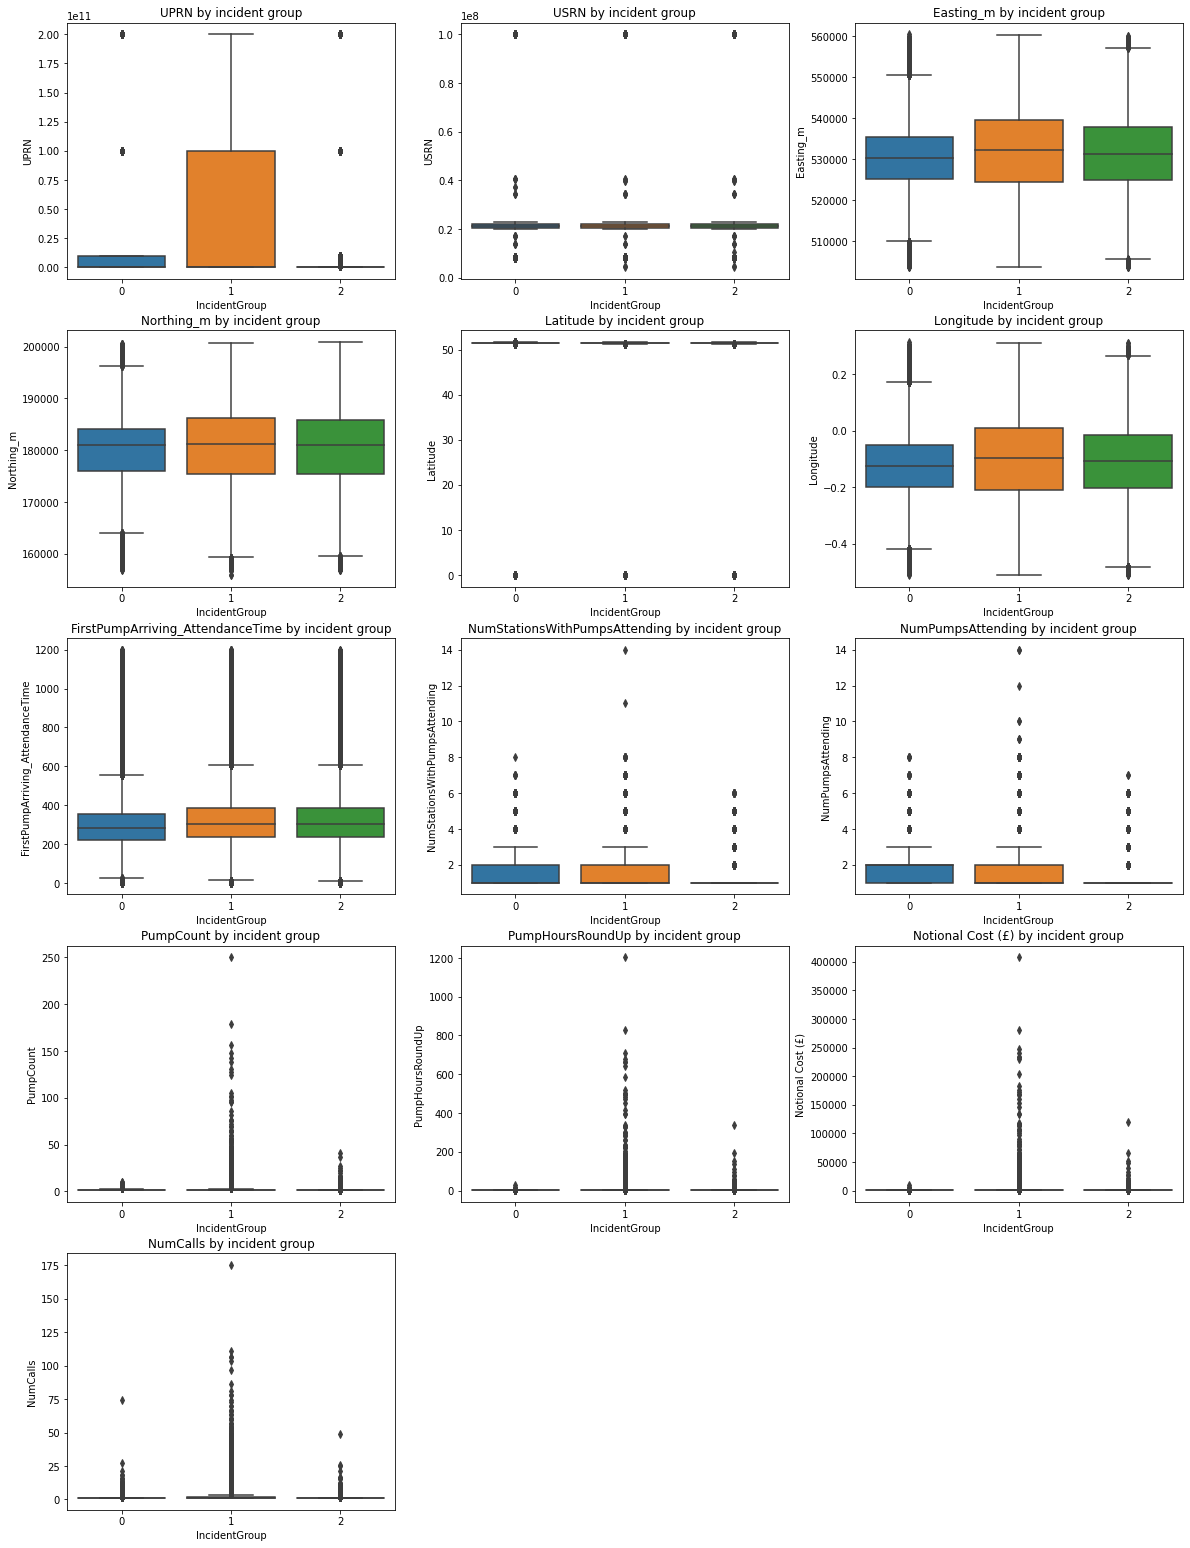

In [16]:
fig = plt.figure(figsize= (20,50))

for i in range(len(df_numeric.columns)):
    column = df_numeric.columns[i]
    sub = fig.add_subplot(9,3, i+1)
    chart = sns.boxplot(data=df_numeric, y=column, x = grouping_labels)
    chart.set_title(column + " by incident group")

#### Missing values on Numeric data

In [17]:
# Check for any missing values
print("Number of cols with Missing Vals: ",df_numeric.isna().any().sum())
display(df_numeric.isna().sum())

Number of cols with Missing Vals:  11


UPRN                                     0
USRN                                     0
Easting_m                           226633
Northing_m                          226633
Latitude                            226633
Longitude                           226633
FirstPumpArriving_AttendanceTime     24652
NumStationsWithPumpsAttending         5288
NumPumpsAttending                     5288
PumpCount                             2980
PumpHoursRoundUp                      3106
Notional Cost (£)                     3106
NumCalls                                 5
dtype: int64

<h6>We need to fix the missing values to cluster around the mean value<br>We will consider randomizing the missing values between 30% and 70%</h6>

#### Missing values

In [18]:

# for i in df_numeric[['UPRN', 'USRN', 'Easting_m', 'Northing_m','Easting_rounded', 'Northing_rounded',
#                     'FirstPumpArriving_AttendanceTime','SecondPumpArriving_AttendanceTime',
#                     'NumStationsWithPumpsAttending', 'NumPumpsAttending', 'PumpCount',
#                     'PumpHoursRoundUp', 'Notional Cost (£)', 'NumCalls']]:
for i in df_numeric.columns.values:
    df_numeric.fillna(0, inplace=True)
    # Set 30 and 70th percentile and round off to 2
    rand_30_70 = random.uniform(round(np.percentile(df_numeric[i],30),2), round(np.percentile(df_numeric[i],70),2)) 
    for j in i:
        if j == 0:
            df_numeric.replace(to_replace=0, value=rand_30_70, inplace=True)
df_numeric.isnull().sum()

UPRN                                0
USRN                                0
Easting_m                           0
Northing_m                          0
Latitude                            0
Longitude                           0
FirstPumpArriving_AttendanceTime    0
NumStationsWithPumpsAttending       0
NumPumpsAttending                   0
PumpCount                           0
PumpHoursRoundUp                    0
Notional Cost (£)                   0
NumCalls                            0
dtype: int64

In [19]:
df_numeric.describe()

,UPRN,USRN,Easting_m,Northing_m,Latitude,Longitude,FirstPumpArriving_AttendanceTime,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,PumpHoursRoundUp,Notional Cost (£),NumCalls
count,4.162130e+05,4.162130e+05,416213.000000,416213.000000,416213.000000,416213.000000,416213.000000,416213.000000,416213.000000,416213.000000,416213.000000,416213.000000,416213.000000
mean,2.044836e+10,2.041624e+07,241723.807548,82138.754123,23.390902,-0.053629,291.990800,1.382343,1.536353,1.597096,1.369092,477.090312,1.323236
std,4.563021e+10,4.584367e+06,264387.626753,89952.320942,25.644851,0.117657,147.214647,0.782350,0.917565,1.492950,5.191339,1804.649568,1.543740
min,0.000000e+00,4.200558e+06,0.000000,0.000000,0.000000,-0.510155,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,2.040102e+07,0.000000,0.000000,0.000000,-0.101954,214.000000,1.000000,1.000000,1.000000,1.000000,339.000000,1.000000
50%,0.000000e+00,2.120117e+07,0.000000,0.000000,0.000000,0.000000,284.000000,1.000000,1.000000,1.000000,1.000000,352.000000,1.000000
75%,1.001405e+10,2.210064e+07,530023.000000,180397.000000,51.507989,0.000000,363.000000,2.000000,2.000000,2.000000,1.000000,364.000000,1.000000
max,2.000044e+11,9.999042e+07,560461.000000,200885.000000,51.691412,0.313635,1200.000000,14.000000,14.000000,250.000000,1203.000000,407817.000000,175.000000


#### Outliers in numerical data

In [20]:
for i in df_numeric.columns:
    df_numeric.fillna(df_numeric[i].mode()[0], inplace = True)
    highest_val = df_numeric[i].mean() + 3*df_numeric[i].std()
    lowest_val = df_numeric[i].mean() - 3*df_numeric[i].std()
    print(f"Range for {i} : ", round(lowest_val,2), " to ",round(highest_val,2))
    
#     Trimming the outliers
    df_numeric[i]= np.where(df_numeric[i]>highest_val, highest_val,
                           np.where(df_numeric[i]<lowest_val, lowest_val,
                                   df_numeric[i]))
#     (df_numeric[i]>=lowest_val)&(df_numeric[i]<=highest_val)

print( "\n","*"*120)
df_numeric.describe().T.apply(lambda s: s.apply('{0:.2f}'.format))

Range for UPRN :  -116442281142.94  to  157339007482.07
Range for USRN :  6663143.55  to  34169344.17
Range for Easting_m :  -551439.07  to  1034886.69
Range for Northing_m :  -187718.21  to  351995.72
Range for Latitude :  -53.54  to  100.33
Range for Longitude :  -0.41  to  0.3
Range for FirstPumpArriving_AttendanceTime :  -149.65  to  733.63
Range for NumStationsWithPumpsAttending :  -0.96  to  3.73
Range for NumPumpsAttending :  -1.22  to  4.29
Range for PumpCount :  -2.88  to  6.08
Range for PumpHoursRoundUp :  -14.2  to  16.94
Range for Notional Cost (£) :  -4936.86  to  5891.04
Range for NumCalls :  -3.31  to  5.95

 ************************************************************************************************************************


,count,mean,std,min,25%,50%,75%,max
UPRN,416213.00,19199155987.22,41051800389.16,0.00,0.00,0.00,10014053014.00,157339007482.07
USRN,416213.00,20337603.14,3698887.59,6663143.55,20401015.00,21201173.00,22100636.00,34169344.17
Easting_m,416213.00,241723.81,264387.63,0.00,0.00,0.00,530023.00,560461.00
Northing_m,416213.00,82138.75,89952.32,0.00,0.00,0.00,180397.00,200885.00
Latitude,416213.00,23.39,25.64,0.00,0.00,0.00,51.51,51.69
Longitude,416213.00,-0.05,0.12,-0.41,-0.10,0.00,0.00,0.30
FirstPumpArriving_AttendanceTime,416213.00,290.23,140.24,0.00,214.00,284.00,363.00,733.63
NumStationsWithPumpsAttending,416213.00,1.36,0.68,0.00,1.00,1.00,2.00,3.73
NumPumpsAttending,416213.00,1.51,0.82,0.00,1.00,1.00,2.00,4.29
PumpCount,416213.00,1.57,0.96,0.00,1.00,1.00,2.00,6.08


In [21]:
df_numeric.isnull().sum()

UPRN                                0
USRN                                0
Easting_m                           0
Northing_m                          0
Latitude                            0
Longitude                           0
FirstPumpArriving_AttendanceTime    0
NumStationsWithPumpsAttending       0
NumPumpsAttending                   0
PumpCount                           0
PumpHoursRoundUp                    0
Notional Cost (£)                   0
NumCalls                            0
dtype: int64

### Categorical Data

In [22]:
df_categorical = LFB_data.select_dtypes(exclude=[np.number])
print(df_categorical.shape)
print( "\n","-"*120)
df_categorical.columns.values

(416213, 15)

 ------------------------------------------------------------------------------------------------------------------------


array(['PropertyCategory', 'PropertyType', 'AddressQualifier',
       'Postcode_district', 'ProperCase', 'Easting_rounded',
       'Northing_rounded', 'FRS', 'IncidentStationGround',
       'FirstPumpArriving_DeployedFromStation', 'YearOfCall',
       'MonthOfCall', 'HourOfCall', 'IncGeo_Borough', 'IncGeo_Ward'],
      dtype=object)

In [23]:
df_categorical.sample(10)

,PropertyCategory,PropertyType,AddressQualifier,Postcode_district,ProperCase,Easting_rounded,Northing_rounded,FRS,IncidentStationGround,FirstPumpArriving_DeployedFromStation,YearOfCall,MonthOfCall,HourOfCall,IncGeo_Borough,IncGeo_Ward
387540,Dwelling,Purpose Built Flats/Maisonettes - 4 to 9 storeys,Correct incident location,SW11,Wandsworth,Easting_rounded_6,Northing_rounded_5,London,Battersea,Battersea,2022,Aug,16,E09000032-WANDSWORTH,E05014028-WANDSWORTH TOWN
378839,Outdoor,Grassland/ pasture/ grazing etc,In street outside gazetteer location,EC1V,Islington,Easting_rounded_1,Northing_rounded_2,London,Islington,Euston,2022,Jul,20,E09000019-ISLINGTON,E05013699-BUNHILL
216662,Non Residential,Prison,Within same building,N7,Islington,Easting_rounded_0,Northing_rounded_4,London,Holloway,Islington,2021,Feb,18,E09000019-ISLINGTON,E05013708-Laycock
56863,Outdoor,Cycle path/public footpath/bridleway,In street close to gazetteer location,E1W,Tower Hamlets,Easting_rounded_4,Northing_rounded_0,London,Shadwell,Whitechapel,2019,Jul,23,E09000030-TOWER HAMLETS,E05009330-St. Katharine's & Wapping
79850,Dwelling,Purpose Built Flats/Maisonettes - 10 or more s...,Within same building,EC1Y,Islington,Easting_rounded_2,Northing_rounded_2,London,Shoreditch,NaN,2019,Oct,00,E09000019-ISLINGTON,E05013699-Bunhill
207027,Dwelling,House - single occupancy,Correct incident location,N15,Haringey,Easting_rounded_2,Northing_rounded_8,London,Tottenham,Tottenham,2021,Jan,03,E09000014-HARINGEY,E05013597-St. Ann's
52866,Other Residential,Retirement/Old Persons Home,Correct incident location,EN1,Enfield,Easting_rounded_2,Northing_rounded_5,London,Edmonton,Edmonton,2019,Jul,07,E09000010-ENFIELD,E05013676-Bush Hill Park
265182,Dwelling,House - single occupancy,Within same building,UB5,Ealing,Easting_rounded_1,Northing_rounded_3,London,Northolt,Northolt,2021,Aug,22,E09000009-EALING,E05013532-Northolt West End
251111,Dwelling,Purpose Built Flats/Maisonettes - 4 to 9 storeys,Correct incident location,W14,Kensington And chelsea,Easting_rounded_4,Northing_rounded_9,London,Hammersmith,Hammersmith,2021,Jun,08,E09000020-KENSINGTON AND CHELSEA,E05009397-HOLLAND
6387,Outdoor,Domestic garden (vegetation not equipment),On land associated with building,NW10,Brent,Easting_rounded_1,Northing_rounded_3,London,Park Royal,Park Royal,2019,Jan,11,E09000005-BRENT,E05013501-Harlesden & Kensal Green


In [24]:
# Show unique values for each categorcal variable

df_categorical.nunique()

PropertyCategory                            9
PropertyType                              283
AddressQualifier                           11
Postcode_district                         305
ProperCase                                 33
Easting_rounded                            10
Northing_rounded                           10
FRS                                         1
IncidentStationGround                     103
FirstPumpArriving_DeployedFromStation     103
YearOfCall                                  4
MonthOfCall                                12
HourOfCall                                 24
IncGeo_Borough                             33
IncGeo_Ward                              1366
dtype: int64

### Joining dataframes

In [25]:
final_df = pd.concat([df_numeric, df_categorical], axis = 1)
final_df.shape

(416213, 28)

In [26]:
final_df.sample(7)

,UPRN,USRN,Easting_m,Northing_m,Latitude,Longitude,FirstPumpArriving_AttendanceTime,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,...,Easting_rounded,Northing_rounded,FRS,IncidentStationGround,FirstPumpArriving_DeployedFromStation,YearOfCall,MonthOfCall,HourOfCall,IncGeo_Borough,IncGeo_Ward
189395,6.211267e+06,22701325.0,537061.0,179402.0,51.496953,-0.026879,153.0,1.0,1.0,1.0,...,Easting_rounded_7,Northing_rounded_9,London,Millwall,Millwall,2020,Nov,22,E09000030-TOWER HAMLETS,E05009323-Canary Wharf
272382,0.000000e+00,20900961.0,0.0,0.0,0.000000,0.000000,0.0,1.0,1.0,1.0,...,Easting_rounded_4,Northing_rounded_4,London,Homerton,NaN,2021,Aug,13,E09000012-HACKNEY,E05009381-LONDON FIELDS
355210,4.807196e+07,22106600.0,525782.0,171957.0,51.432666,-0.191919,299.0,1.0,1.0,1.0,...,Easting_rounded_5,Northing_rounded_1,London,Wimbledon,Wimbledon,2022,May,09,E09000024-MERTON,E05013828-Wimbledon Park
8743,0.000000e+00,21106469.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,Easting_rounded_2,Northing_rounded_0,London,Tottenham,NaN,2019,Feb,15,E09000014-HARINGEY,E05013603-West Green
38047,1.001011e+08,19900159.0,547047.0,187015.0,51.562849,0.120052,330.0,1.0,1.0,1.0,...,Easting_rounded_7,Northing_rounded_7,London,Dagenham,Ilford,2019,May,17,E09000002-BARKING AND DAGENHAM,E05014057-Becontree
343482,1.000236e+11,22005521.0,537062.0,176915.0,51.474602,-0.027839,184.0,1.0,1.0,1.0,...,Easting_rounded_7,Northing_rounded_6,London,Greenwich,Greenwich,2022,Apr,21,E09000023-LEWISHAM,E05013719-Deptford
316723,1.001005e+08,19900718.0,544092.0,184494.0,51.540959,0.076410,330.0,1.0,1.0,1.0,...,Easting_rounded_4,Northing_rounded_4,London,Barking,Barking,2022,Jan,14,E09000002-BARKING AND DAGENHAM,E05014066-Northbury


### One hot encoding

In [27]:
final_df = pd.get_dummies(final_df)
final_df.tail()

,UPRN,USRN,Easting_m,Northing_m,Latitude,Longitude,FirstPumpArriving_AttendanceTime,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,...,IncGeo_Ward_E05014115-STREATHAM ST. LEONARD'S,IncGeo_Ward_E05014115-Streatham St. Leonard's,IncGeo_Ward_E05014116-STREATHAM WELLS,IncGeo_Ward_E05014116-Streatham Wells,IncGeo_Ward_E05014117-VAUXHALL,IncGeo_Ward_E05014117-Vauxhall,IncGeo_Ward_E05014118-WATERLOO & SOUTH BANK,IncGeo_Ward_E05014118-Waterloo & South Bank,IncGeo_Ward_E05014119-WEST DULWICH,IncGeo_Ward_E05014119-West Dulwich
416208,0.000000e+00,20800328.0,0.0,0.0,0.000000,0.000000,189.0,2.0,3.0,3.0,...,0,0,0,0,0,0,0,0,0,0
416209,1.000235e+11,8401081.0,528087.0,181625.0,51.519032,-0.155286,318.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
416210,0.000000e+00,21701005.0,0.0,0.0,0.000000,0.000000,269.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
416211,0.000000e+00,8400481.0,0.0,0.0,0.000000,0.000000,346.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
416212,1.000234e+11,21400966.0,505545.0,184151.0,51.546398,-0.406600,281.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0


#### Adding the grouping data (labels)

In [28]:
final_df = pd.concat([grouping_labels, final_df], axis=1)
final_df.head(5)

,IncidentGroup,UPRN,USRN,Easting_m,Northing_m,Latitude,Longitude,FirstPumpArriving_AttendanceTime,NumStationsWithPumpsAttending,NumPumpsAttending,...,IncGeo_Ward_E05014115-STREATHAM ST. LEONARD'S,IncGeo_Ward_E05014115-Streatham St. Leonard's,IncGeo_Ward_E05014116-STREATHAM WELLS,IncGeo_Ward_E05014116-Streatham Wells,IncGeo_Ward_E05014117-VAUXHALL,IncGeo_Ward_E05014117-Vauxhall,IncGeo_Ward_E05014118-WATERLOO & SOUTH BANK,IncGeo_Ward_E05014118-Waterloo & South Bank,IncGeo_Ward_E05014119-WEST DULWICH,IncGeo_Ward_E05014119-West Dulwich
0,2,0.0,21901674.0,0.0,0.0,0.000000,0.000000,0.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,1,207088775.0,20704497.0,534494.0,194099.0,51.629641,-0.058219,357.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,0,200100401.0,20037660.0,527630.0,193922.0,51.629649,-0.157400,318.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,0,0.0,8400731.0,0.0,0.0,0.000000,0.000000,210.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,2,0.0,22700484.0,0.0,0.0,0.000000,0.000000,329.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0


# Dimensionality reduction

In [29]:
random.seed(10)
rand_num=random.sample(range(len(final_df)), 100000)
rand_num[:10]

[299579, 17083, 224861, 253001, 303086, 7776, 108054, 242525, 257580, 145500]

In [30]:
working_df = final_df.iloc[rand_num]

In [31]:
working_df.shape

(100000, 2321)

## T-Stochastic Neighbor Embedding (t-SNE)

In [32]:
%%time
import scipy
import time
from scipy.spatial.distance import pdist
from sklearn.manifold import TSNE
from scipy import stats
# A=scipy.spatial.distance.pdist(working_df, metric='euclidean')
# kendTSNE=[]
tsne = TSNE(n_components = 2, verbose=1, learning_rate=200, n_iter=500)
tsne_result = tsne.fit_transform(X=working_df)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100000 samples in 7.407s...


MemoryError: Unable to allocate 1.00 GiB for an array with shape (1342, 100000) and data type float64

In [33]:
tsne_df = pd.DataFrame({"t-SNE 1":tsne_result[:,0], "t-SNE 2":tsne_result[:,1], "label":working_df['IncidentGroup']})
tsne_df.head()

NameError: name 'tsne_result' is not defined

In [ ]:
# Plotting the tsne data

fig, ax = plt.subplots(1, figsize=(15,10))
sns.scatterplot(x = 't-SNE 1', y= 't-SNE 2', data = tsne_df, hue='label', ax = ax, s=25, palette = 'dark')
sns.color_palette("hls", 10)
lim = (tsne_df.min()-5, tsne_df.max()+5)
ax.set_title('t-SNE Visualization of Incident Group', fontsize = 16, weight = 'bold')
ax.legend(bbox_to_anchor = (1,1), loc =2, borderaxespad = 0.0)

## Same Degree Distribution

In [ ]:
from scipy import linalg
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.sparse import csr_matrix, issparse
from sklearn.neighbors import NearestNeighbors
from sklearn.base import BaseEstimator
from sklearn.utils import check_random_state
from sklearn.utils._openmp_helpers import _openmp_effective_n_threads
from sklearn.utils.validation import check_non_negative
from sklearn.utils.validation import _deprecate_positional_args
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances

MACHINE_EPSILON = np.finfo(np.double).eps

In [ ]:
def _joint_probabilities(X, degrees_of_freedom):
    dist = pdist(X, "sqeuclidean")
    dist += 1.
    dist **= (-degrees_of_freedom)
    P= np.maximum(dist / ( np.sum(dist)), MACHINE_EPSILON)
    return P


def _kl_divergence(params, P, degrees_of_freedom, n_samples, n_components,
                  skip_num_points=0, compute_error=True):

    X_embedded = params.reshape(n_samples, n_components)
    dist = pdist(X_embedded, "sqeuclidean")
    Dist=dist+ 1.
    dist= Dist**(-degrees_of_freedom)
    Q = np.maximum(dist / (np.sum(dist)), MACHINE_EPSILON)
    dist1=Dist**(-1)
    kl_divergence =np.dot(P, np.log(np.maximum(P, MACHINE_EPSILON) / Q))
    grad = np.ndarray((n_samples, n_components), dtype=params.dtype)
    PQd = squareform((P - Q) * dist1)
    for i in range(skip_num_points, n_samples):
        grad[i] = np.dot(np.ravel(PQd[i]),
                        X_embedded[i] - X_embedded)
    grad = grad.ravel()
    c = 2*(degrees_of_freedom + 1.0) 
    grad *= c

    return kl_divergence, grad

def _gradient_descent(objective, p0, it, n_iter,
                     n_iter_check=1, n_iter_without_progress=300,
                     momentum=0.5, learning_rate=7, min_gain=0.01,
                     min_grad_norm=1e-7, verbose=0, args=None, kwargs=None):
    if args is None:
        args = []
    if kwargs is None:
        kwargs = {}

    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = i = it

    tic = time()
    for i in range(it, n_iter):
        check_convergence = (i + 1) % n_iter_check == 0
       
        kwargs['compute_error'] = check_convergence or i == n_iter - 1

        error, grad = objective(p, *args, **kwargs)
        grad_norm = linalg.norm(grad)

        inc = update * grad < 0.0
        dec = np.invert(inc)
        gains[inc] += 0.2
        gains[dec] *= 0.8
        np.clip(gains, min_gain, np.inf, out=gains)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update

        if check_convergence:
            toc = time()
            duration = toc - tic
            tic = toc

            if verbose >= 2:
                print("[t-SNE] Iteration %d: error = %.7f,"
                     " gradient norm = %.7f"
                     " (%s iterations in %0.3fs)"
                     % (i + 1, error, grad_norm, n_iter_check, duration))

            if error < best_error:
                best_error = error
                best_iter = i
            elif i - best_iter > n_iter_without_progress:
                if verbose >= 2:
                    print("[t-SNE] Iteration %d: did not make any progress "
                         "during the last %d episodes. Finished."
                         % (i + 1, n_iter_without_progress))
                break
            if grad_norm <= min_grad_norm:
                if verbose >= 2:
                    print("[t-SNE] Iteration %d: gradient norm %f. Finished."
                         % (i + 1, grad_norm))
                break

    return p, error, i


class SDD(BaseEstimator):
   
   
    _EXPLORATION_N_ITER = 300
    _N_ITER_CHECK =50
    def _fit(self, X, degrees_of_freedom, skip_num_points=0):
        random_state=None
        n_samples=X.shape[0]
        P = _joint_probabilities(X,degrees_of_freedom)

        random_state = check_random_state(random_state)

        X_embedded = 1e-4 * random_state.randn(
               n_samples, 2).astype(np.float32)

        return self._tsne(P, degrees_of_freedom, n_samples,X_embedded=X_embedded,skip_num_points=skip_num_points)
    def _tsne(self, P, degrees_of_freedom, n_samples, X_embedded, skip_num_points=0):
        """Runs t-SNE."""
        params = X_embedded.ravel()

        opt_args = {
           "it": 0,
           "n_iter_check": 50,
           "min_grad_norm": 1e-7,
           "learning_rate": 7,
           "verbose": 0,
           "kwargs": dict(skip_num_points=skip_num_points),
           "args": [P, degrees_of_freedom, n_samples, 2],
           "n_iter_without_progress": 300,
           "n_iter": 300,
           "momentum": 0.8,
       }
        obj_func = _kl_divergence

        params, kl_divergence, it = _gradient_descent(obj_func, params,
                                                     **opt_args)
        P /= 1
        remaining =2000 - 300
        if it < 300 or remaining > 0:
            opt_args['n_iter'] = 2000
            opt_args['it'] = it + 1
            opt_args['momentum'] = 0.8
            opt_args['n_iter_without_progress'] = 300
            params, kl_divergence, it = _gradient_descent(obj_func, params,
                                                         **opt_args)

        self.n_iter_ = it
        X_embedded = params.reshape(n_samples, 2)
        self.kl_divergence_ = kl_divergence

        return X_embedded
